In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import joblib
import warnings
warnings.filterwarnings("ignore")

sns.set_style("whitegrid")

In [2]:
diabetes_dataset = pd.read_csv('diabetes.csv')
diabetes_dataset.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [3]:
diabetes_dataset.shape

(768, 9)

In [4]:
diabetes_dataset.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [5]:
diabetes_dataset['Outcome'].value_counts()

Outcome
0    500
1    268
Name: count, dtype: int64

In [6]:
diabetes_dataset.groupby('Outcome').mean()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
Outcome,,,,,,,,
0,3.298000,109.980000,68.184000,19.664000,68.792000,30.304200,0.429734,31.190000
1,4.865672,141.257463,70.824627,22.164179,100.335821,35.142537,0.550500,37.067164


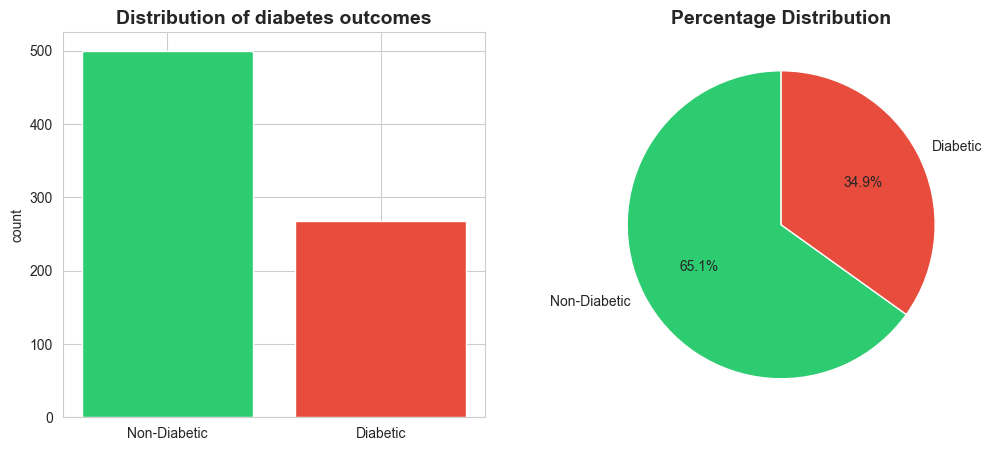

In [7]:
plt.figure(figsize=(12, 5))
plt.subplot(1,2,1)
outcome_counts = diabetes_dataset['Outcome'].value_counts()
plt.bar(['Non-Diabetic', 'Diabetic'], outcome_counts.values, color=['#2ecc71','#e74c3c'])
plt.title('Distribution of diabetes outcomes', fontsize=14, fontweight='bold')
plt.ylabel('count')

plt.subplot(1,2,2)
plt.pie(
    outcome_counts.values,
    labels=['Non-Diabetic', 'Diabetic'],
    autopct='%1.1f%%',
    colors=['#2ecc71', '#e74c3c'],  
    startangle=90
)
plt.title('Percentage Distribution', fontsize=14, fontweight='bold')
plt.show()

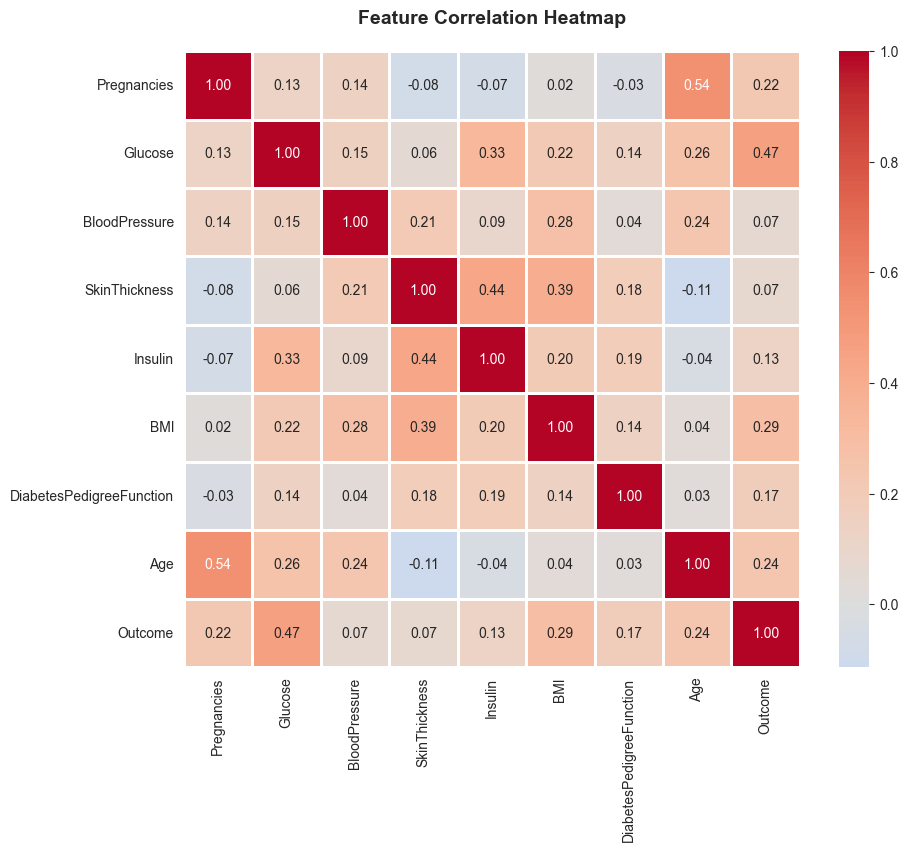

In [8]:
plt.figure(figsize=(10,8))
correlation = diabetes_dataset.corr()
sns.heatmap(correlation, annot= True, cmap= 'coolwarm', center=0, square =True, linewidth=1, fmt ='.2f')
plt.title('Feature Correlation Heatmap', fontsize=14, pad=20, fontweight= 'bold')
plt.show()

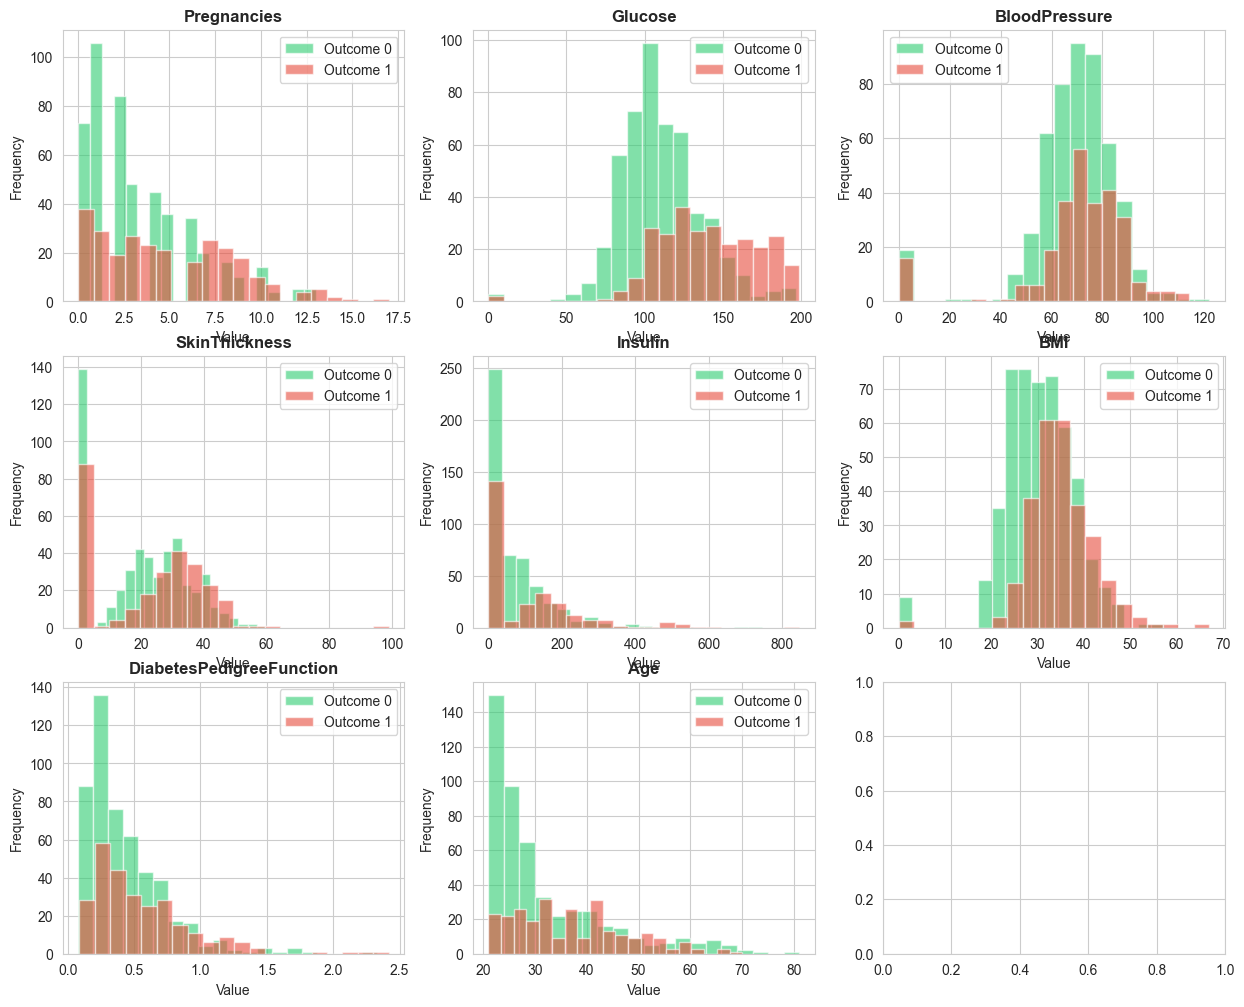

In [9]:
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
features = diabetes_dataset.columns[:-1]

for idx, feature in enumerate(features):
    row, col = idx // 3, idx % 3
    for outcome in [0, 1]:
        data = diabetes_dataset[diabetes_dataset['Outcome'] == outcome][feature]
        axes[row, col].hist(data, alpha=0.6,bins=20,label=f'Outcome {outcome}',  
            color=['#2ecc71', '#e74c3c'][outcome])
        axes[row, col].set_title(feature, fontweight='bold')
        axes[row, col].set_xlabel('Value')
        axes[row, col].set_ylabel('Frequency')
        axes[row, col].legend()

plt.show()

In [10]:
X = diabetes_dataset.drop(columns = 'Outcome',axis = 1)
Y = diabetes_dataset['Outcome']

print(X)
print(Y)

     Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0              6      148             72             35        0  33.6   
1              1       85             66             29        0  26.6   
2              8      183             64              0        0  23.3   
3              1       89             66             23       94  28.1   
4              0      137             40             35      168  43.1   
..           ...      ...            ...            ...      ...   ...   
763           10      101             76             48      180  32.9   
764            2      122             70             27        0  36.8   
765            5      121             72             23      112  26.2   
766            1      126             60              0        0  30.1   
767            1       93             70             31        0  30.4   

     DiabetesPedigreeFunction  Age  
0                       0.627   50  
1                       0.351   31  


In [11]:
scaler = StandardScaler()
X = scaler.fit_transform(X)
X

array([[ 0.63994726,  0.84832379,  0.14964075, ...,  0.20401277,
         0.46849198,  1.4259954 ],
       [-0.84488505, -1.12339636, -0.16054575, ..., -0.68442195,
        -0.36506078, -0.19067191],
       [ 1.23388019,  1.94372388, -0.26394125, ..., -1.10325546,
         0.60439732, -0.10558415],
       ...,
       [ 0.3429808 ,  0.00330087,  0.14964075, ..., -0.73518964,
        -0.68519336, -0.27575966],
       [-0.84488505,  0.1597866 , -0.47073225, ..., -0.24020459,
        -0.37110101,  1.17073215],
       [-0.84488505, -0.8730192 ,  0.04624525, ..., -0.20212881,
        -0.47378505, -0.87137393]], shape=(768, 8))

In [12]:
x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size = 0.2, stratify= Y, random_state = 2)
print(X.shape, x_train.shape, x_test.shape)

(768, 8) (614, 8) (154, 8)


In [13]:
classifier = svm.SVC(kernel= 'linear', probability = True)
classifier.fit(x_train,y_train)

,C,1.0
,kernel,'linear'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,True
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


In [14]:
x_train_prediction = classifier.predict(x_train)
training_data_accuracy = accuracy_score(x_train_prediction, y_train)
training_data_accuracy

0.7866449511400652

In [15]:
x_test_prediction = classifier.predict(x_test)
test_data_accuracy = accuracy_score(x_test_prediction, y_test)
test_data_accuracy

0.7727272727272727

In [16]:
precision = precision_score(y_test, x_test_prediction)
recall = recall_score(y_test, x_test_prediction)
f1 = f1_score(y_test, x_test_prediction)

print(precision,recall,f1)

0.7567567567567568 0.5185185185185185 0.6153846153846154


In [17]:
cm_svm = confusion_matrix(y_test, x_test_prediction)
cm_svm

array([[91,  9],
       [26, 28]])

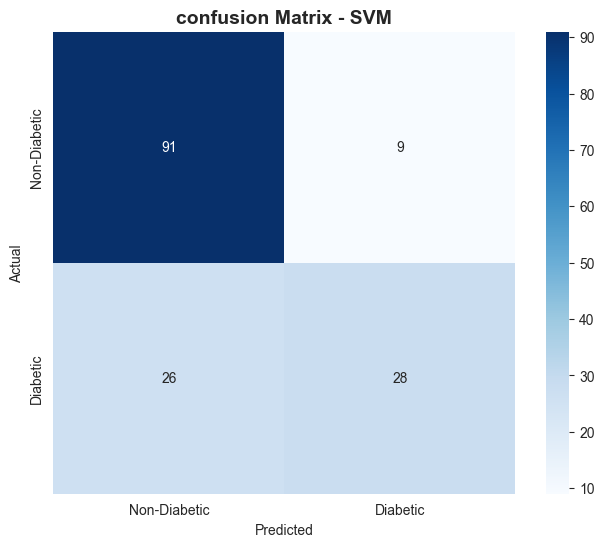

In [18]:
plt.figure(figsize= (8,6))
sns.heatmap(cm_svm, annot = True, fmt= 'd', cmap = 'Blues', square = True,
            xticklabels= ['Non-Diabetic','Diabetic'],
            yticklabels= ['Non-Diabetic', 'Diabetic'])
plt.title('confusion Matrix - SVM', fontsize= 14, fontweight= 'bold')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [19]:
rf_classifier = RandomForestClassifier(n_estimators =100, random_state= 2)
rf_classifier.fit(x_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [20]:
x_train_prediction_rf = rf_classifier.predict(x_train)

In [21]:
training_data_accuracy_rf = accuracy_score(x_train_prediction_rf, y_train)
training_data_accuracy_rf

1.0

In [22]:
x_test_prediction_rf = rf_classifier.predict(x_test)
test_data_accuracy_rf = accuracy_score(x_test_prediction_rf, y_test)
test_data_accuracy_rf

0.7272727272727273

In [23]:
precision_rf = precision_score(y_test, x_test_prediction_rf)
recall_rf = recall_score(y_test, x_test_prediction_rf)
f1_rf = f1_score(y_test, x_test_prediction_rf)

print(precision_rf,recall_rf,f1_rf)

0.65 0.48148148148148145 0.5531914893617021


In [24]:
cm_rf = confusion_matrix(y_test, x_test_prediction_rf)
cm_rf

array([[86, 14],
       [28, 26]])

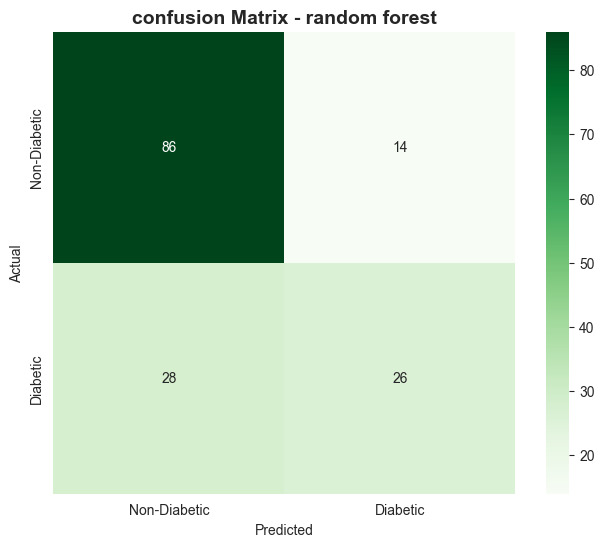

In [25]:
plt.figure(figsize= (8,6))
sns.heatmap(cm_rf, annot = True, fmt= 'd', cmap = 'Greens', square = True,
            xticklabels= ['Non-Diabetic','Diabetic'],
            yticklabels= ['Non-Diabetic', 'Diabetic'])
plt.title('confusion Matrix - random forest', fontsize= 14, fontweight= 'bold')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [26]:
print('SVM', test_data_accuracy)
print('Random Forest', test_data_accuracy_rf)

SVM 0.7727272727272727
Random Forest 0.7272727272727273


In [27]:
joblib.dump(classifier, 'diabetes_model.pkl')

['diabetes_model.pkl']

In [28]:
input_data = (5,166,72,19,0,25.8,0.587,51)

input_num_array = np.asarray(input_data)
reshape = input_num_array.reshape(1, -1)

std_data = scaler.transform(reshape)
prediction = classifier.predict(std_data)

print(prediction)

[1]


In [30]:
joblib.dump(scaler, "scaler_svm.pkl")

['scaler_svm.pkl']

In [29]:
pip install streamlit

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 26.0
[notice] To update, run: python.exe -m pip install --upgrade pip
